In [107]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from utils import *
from scipy.fft import fft
import os
from jax import random
from jax.experimental.optimizers import adam, sgd
from jax import numpy as jnp
%load_ext autoreload
%autoreload 2
from models.newton_ode import mse, initialize_params, batch_forward_pass, get_loss_function, train, forward_pass
from tqdm import tqdm

from utils import Shuffler


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
3.9823//2

1.0

In [ ]:


freq = 9
polyorder = 3
window_length = 77

def get_data(freq, polyorder=3, window_length=151):
    
    all_data = pd.DataFrame()
    for file in filter(lambda x: ("_"+str(freq)+"Hz" in x) and x.endswith(".txt"), os.listdir("amb_sin/")):
        print(file)
        df = load_amb_sin_data("amb_sin/" + file).iloc[10000:]
        df["f_ay"] -= df["f_ay"].mean()
        df["f_ax"] -= df["f_ax"].mean()
        df["f_bx"] -= df["f_bx"].mean()
        df["f_by"] -= df["f_by"].mean()
        df["x"] = (df["ax"] + df["bx"])/2
        #df["x"] = df["ax"]
        df["y"] = (df["ay"] + df["by"])/2
        #df["y"] = df["ay"]
        df['fx'] = df["f_ax"] + df["f_bx"]
        #df["fx"] = df["f_ax"]
        df['fy'] = df["f_ay"] + df["f_by"]
        #df["fx"] = df["f_ay"]
        df = df[["datetime", "x", "y", "fx", "fy"]]
        
        
        mean_dt = (df["datetime"] - df["datetime"].shift()).median().delta*1e-9
        for col in ["x", "y"]:
            df = append_derivatives_to_dataframe(df, col, dt=mean_dt, window_length=window_length, polyorder=polyorder)

        df = append_derivatives_to_dataframe(df, "fx", dt=mean_dt, window_length=window_length, polyorder=polyorder)
        df = append_derivatives_to_dataframe(df, "fy", dt=mean_dt, window_length=window_length, polyorder=polyorder)

        
        
        df["x_t1"] = df["x"].shift()
        df["y_t1"] = df["y"].shift()
        df["fx_t1"] = df["fx"].shift()
        df["fy_t1"] = df["fy"].shift()
        df["x_dot_t1"] = df["x_dot"].shift()
        df["y_dot_t1"] = df["y_dot"].shift()
        df["fx_dot_t1"] = df["fx"].shift()
        df["fy_dot_t1"] = df["fy"].shift()
        
        df = df.iloc[1:]
        
        all_data = pd.concat([all_data, df], ignore_index=True)
    
    return all_data

def get_vectors_from_data(df):
    q = np.expand_dims(df[['x', 'y']].values, axis=-1)
    q_dot = np.expand_dims(df[['x_dot', 'y_dot']].values, axis=-1)
    q_dot2 = np.expand_dims(df[['x_dot2', 'y_dot2']].values, axis=-1)
    f = np.expand_dims(df[['fx', 'fy']].values, axis=-1)
    
    q_t1 = np.expand_dims(df[['x_t1', 'y_t1']].values, axis=-1)
    q_dot_t1 = np.expand_dims(df[['x_dot_t1', 'y_dot_t1']].values, axis=-1)
    f_t1 = np.expand_dims(df[['fx_t1', 'fy_t1']].values, axis=-1)
    
    return q, q_dot, q_dot2, f, q_t1, q_dot_t1, f_t1


df = get_data(freq=47)

In [114]:
q, q_dot, q_dot2, f, q_t1, q_dot_t1, f_t1 = get_vectors_from_data(df)

  0%|          | 0/3054 [00:00<?, ?it/s]

Epoch 0


100%|██████████| 3054/3054 [00:33<00:00, 91.74it/s] 


Epoch 0 , mean error: 1.2780601e-08 params: [DeviceArray([[-2426.0403 ,  -206.07695],
             [ -500.39954, -3602.8123 ]], dtype=float32), DeviceArray([[849.495   , -20.810387],
             [127.38276 , 973.69995 ]], dtype=float32)]


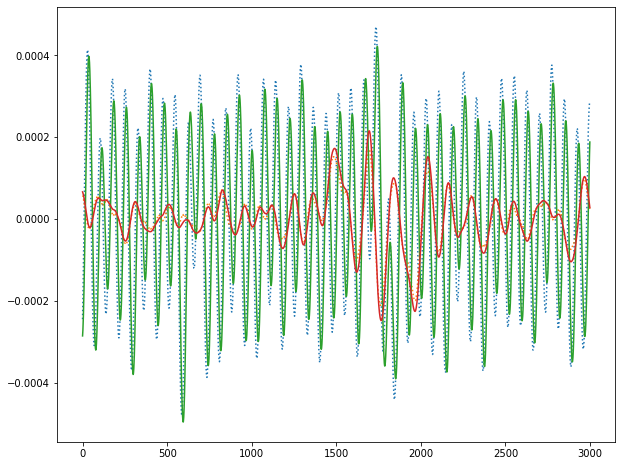

  0%|          | 10/3054 [00:00<00:30, 99.47it/s]

Epoch 1


 85%|████████▌ | 2600/3054 [00:24<00:04, 104.48it/s]


KeyboardInterrupt: 

In [120]:
rng = random.PRNGKey(15)
params = initialize_params(rng, dims=2, scale=1)

window = 3000

shuffler = Shuffler(len(q))
q_shuffled = shuffler.shuffle(q)
q_dot_shuffled = shuffler.shuffle(q_dot)
q_dot2_shuffled = shuffler.shuffle(q_dot2)
f_shuffled = shuffler.shuffle(f)

q_shuffled_t1 = shuffler.shuffle(q_t1)
q_dot_shuffled_t1 = shuffler.shuffle(q_dot_t1)

def callback(y_pred, y_true):

    plt.figure(figsize=(10, 8))
    random_ind = int(np.random.uniform(0, len(y_pred) - window - 1))
    plt.plot(shuffler.undo_shuffle(np.squeeze(y_pred))[random_ind:(random_ind + window)], linestyle="dotted")
    plt.plot(shuffler.undo_shuffle(np.squeeze(y_true))[random_ind:(random_ind + window)])
    plt.show()


params=train(params, q_shuffled, q_dot_shuffled, q_dot2_shuffled, f_shuffled, q_shuffled_t1, q_dot_shuffled_t1, batch_size=32, optimizer=adam, step_size=1e4, epochs=15, callback=callback, batch_forward_pass=batch_forward_pass)

In [330]:
q_dot

array([[[ 0.00608435],
        [-0.00102834]],

       [[ 0.00608138],
        [-0.00102428]],

       [[ 0.00607796],
        [-0.00102019]],

       ...,

       [[-0.00026335],
        [-0.00189617]],

       [[-0.00025233],
        [-0.00198711]],

       [[-0.00024122],
        [-0.0020786 ]]])

(0.0, 5000.0)

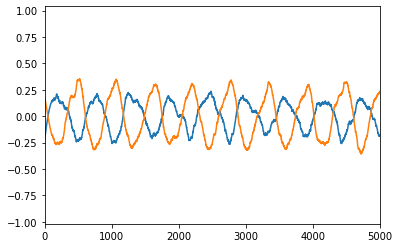

In [331]:
plt.plot(df["fy"])
plt.plot(df["fx"])
plt.xlim((0, 5000))

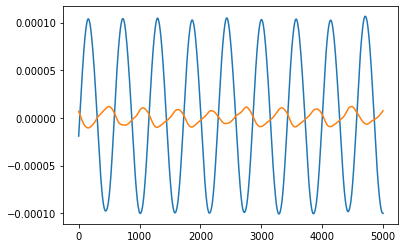

In [332]:
plt.plot(np.squeeze(q)[:5000])

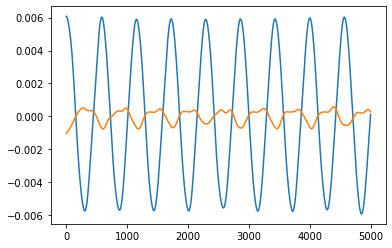

In [333]:
plt.plot(np.squeeze(q_dot)[:5000])

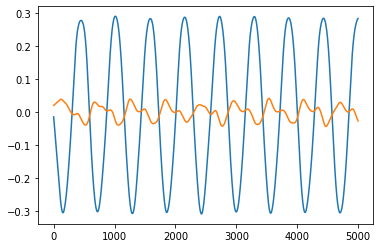

In [334]:
plt.plot(np.squeeze(q_dot2)[:5000])

(0.0, 500.0)

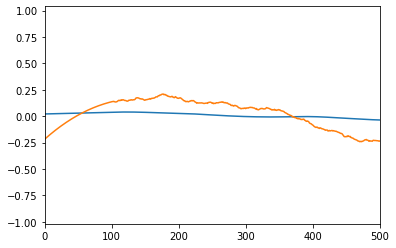

In [335]:
plt.plot(df["y_dot2"])
plt.plot(df["fy"])
plt.xlim((0, 500))

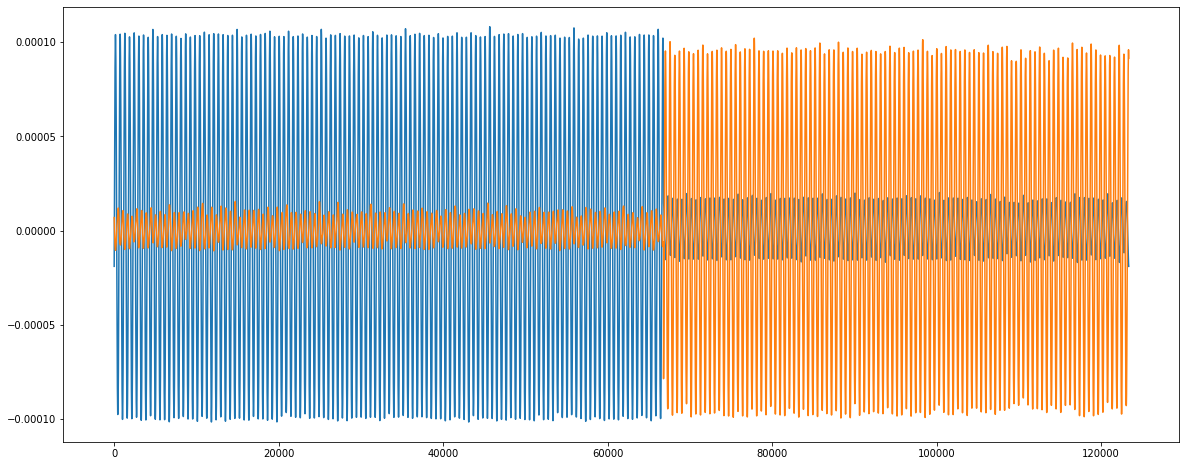

In [336]:
plt.figure(figsize=(20, 8))
plt.plot(np.squeeze(q))

In [72]:
from jax.experimental.ode import odeint

mass = jnp.array([[1, 0], [0, 1]])
g = jnp.array([[0], [0]])

def dynamics_fun(y, t, f, params):
    """

    :param y: inputs [position, velocity]
    :param t: time
    :param f: force
    :return: outputs dydt [velocity, acceleration]
    """

    q, q_dot = jnp.split(y.reshape((-1)), 2)

    q = q.reshape((-1, 1))
    q_dot = q_dot.reshape((-1, 1))
    f = f.reshape((-1, 1))
    M_inv = np.linalg.pinv(mass)
    C = params[1] @ q_dot
    K = params[0] @ q

    q_dot2 = jnp.squeeze(M_inv @ (f - C - K) - g, -1)

    dydt = jnp.concatenate([q_dot.flatten(), q_dot2.flatten()], axis=0)

    return dydt

def forward_pass(params, q, q_dot, f):
    """
    Uma instancia de x é do formato [x, x_dot]
    Um forward pass estima a aceleração do sistema

    """
    q = q.reshape((-1,))
    q_dot = q_dot.reshape((-1,))
    y =  jnp.concatenate([q, q_dot])

    ysol = odeint(dynamics_fun, y, jnp.linspace(0., 0.000195, num=50), *(f, params))[-1]
    
    print(ysol)
    
    q, q_dot = jnp.split(ysol, 2)
    return q

rng = random.PRNGKey(15)
params = initialize_params(rng, dims=2, scale=1000)
forward_pass(params, jnp.array([[1.], [1.3]]), jnp.array([[1.], [0.006]]), jnp.array([[1.], [1.2]]))

[ 1.0002353  1.2999784  1.4295319 -0.2490561]


DeviceArray([1.0002353, 1.2999784], dtype=float32)

DeviceArray([0.00000000e+00, 3.97959184e-06, 7.95918368e-06,
             1.19387760e-05, 1.59183674e-05, 1.98979596e-05,
             2.38775519e-05, 2.78571442e-05, 3.18367347e-05,
             3.58163270e-05, 3.97959193e-05, 4.37755116e-05,
             4.77551039e-05, 5.17346925e-05, 5.57142885e-05,
             5.96938771e-05, 6.36734694e-05, 6.76530617e-05,
             7.16326540e-05, 7.56122463e-05, 7.95918386e-05,
             8.35714309e-05, 8.75510232e-05, 9.15306155e-05,
             9.55102078e-05, 9.94897928e-05, 1.03469385e-04,
             1.07448977e-04, 1.11428577e-04, 1.15408169e-04,
             1.19387754e-04, 1.23367354e-04, 1.27346939e-04,
             1.31326524e-04, 1.35306123e-04, 1.39285723e-04,
             1.43265308e-04, 1.47244893e-04, 1.51224493e-04,
             1.55204078e-04, 1.59183677e-04, 1.63163262e-04,
             1.67142862e-04, 1.71122447e-04, 1.75102046e-04,
             1.79081631e-04, 1.83061231e-04, 1.87040816e-04,
             1.91020416e

# Treinamento q_dot2

In [352]:
from jax import random
from jax.experimental.optimizers import adam, sgd
from jax import numpy as jnp
%load_ext autoreload
%autoreload 2
from models.newton import mse, initialize_params, get_batch_forward_pass, get_loss_function, train
from tqdm import tqdm

from utils import Shuffler

rng = random.PRNGKey(15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [353]:
params = initialize_params(rng, dims=2, scale=1)
batch_forward_pass = get_batch_forward_pass(mass=[[1, 0],[0, 1]], g=jnp.array([[0],[0]]))

In [354]:

shuffler = Shuffler(len(q))
q_shuffled = shuffler.shuffle(q)
q_dot_shuffled = shuffler.shuffle(q_dot)
q_dot2_shuffled = shuffler.shuffle(q_dot2)
f_shuffled = shuffler.shuffle(f)

In [355]:
params

[DeviceArray([[ 0.09981377, -1.6656423 ],
              [ 0.17985861,  0.14516467]], dtype=float32),
 DeviceArray([[ 0.08199833,  2.0304651 ],
              [ 0.77214444, -0.07478045]], dtype=float32)]

In [356]:
#params = [jnp.array([[-302540.24339204,    8293.15047838],
#                     [-3526.76033189, -291654.7198465 ]]),
#          jnp.array([[23.24364829, -3.40466658],
#                     [-1.39629066, 38.48061365]])]

In [357]:
params[0] = params[0] + jnp.array([[1e5, 0], [0, 1e5]])
params

[DeviceArray([[ 1.0000010e+05, -1.6656423e+00],
              [ 1.7985861e-01,  1.0000015e+05]], dtype=float32),
 DeviceArray([[ 0.08199833,  2.0304651 ],
              [ 0.77214444, -0.07478045]], dtype=float32)]

  0%|          | 1/3855 [00:00<10:54,  5.89it/s]

Epoch 0


100%|██████████| 3855/3855 [00:25<00:00, 151.90it/s]


Epoch 0 , mean error: 4.1155105 params: [DeviceArray([[3394.3499 , 4511.966  ],
             [1939.369  , -586.12756]], dtype=float32), DeviceArray([[ 14.879861, -16.05416 ],
             [ -6.652686,  18.637156]], dtype=float32)]


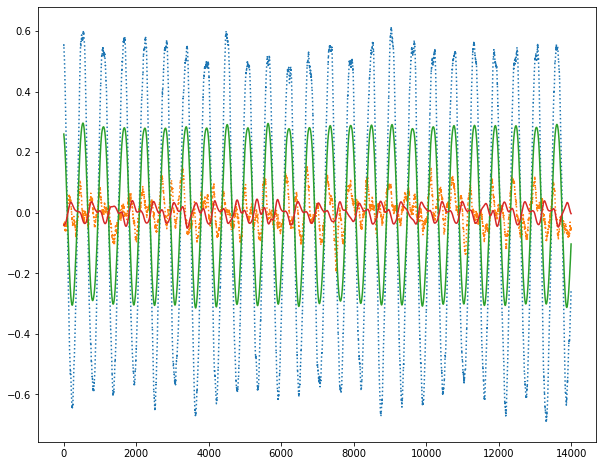

  0%|          | 16/3855 [00:00<00:25, 151.97it/s]

Epoch 1


100%|██████████| 3855/3855 [00:25<00:00, 152.35it/s]


Epoch 1 , mean error: 0.004043463 params: [DeviceArray([[  535.989 ,  3653.9495],
             [ 1006.3755, -5198.132 ]], dtype=float32), DeviceArray([[ 18.239346, -21.460587],
             [ -4.268244,  31.00705 ]], dtype=float32)]


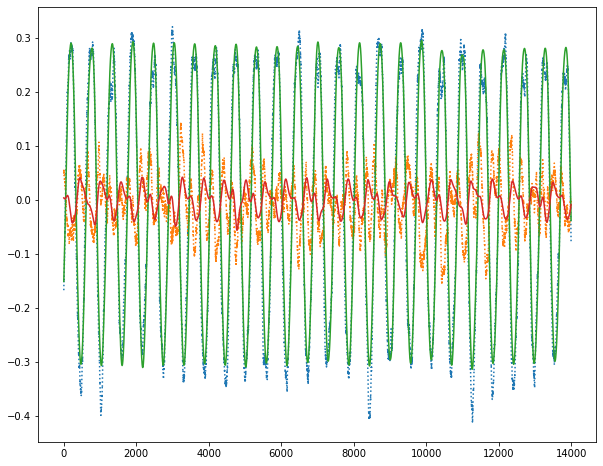

  0%|          | 14/3855 [00:00<00:28, 134.95it/s]

Epoch 2


100%|██████████| 3855/3855 [00:26<00:00, 147.96it/s]


Epoch 2 , mean error: 0.0017685961 params: [DeviceArray([[  554.99335,  3719.409  ],
             [  997.123  , -5203.696  ]], dtype=float32), DeviceArray([[ 2.0325308e+01, -1.8763779e+01],
             [-9.1960728e-03,  2.9490564e+01]], dtype=float32)]


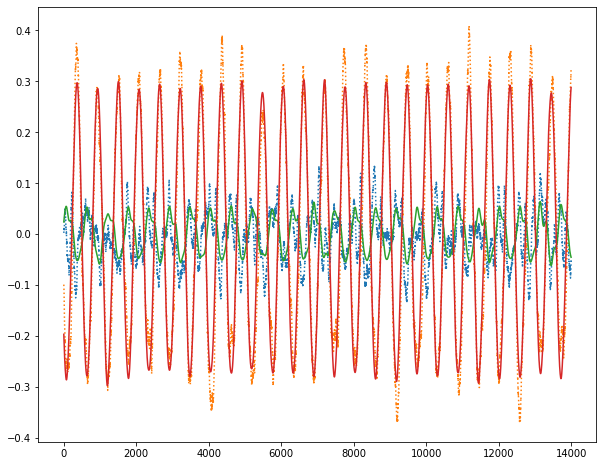

  0%|          | 15/3855 [00:00<00:26, 146.51it/s]

Epoch 3


 11%|█         | 423/3855 [00:02<00:23, 144.44it/s]


KeyboardInterrupt: 

In [359]:
window = 14000

def callback(y_pred, y_true):
    
    plt.figure(figsize=(10, 8))
    random_ind = int(np.random.uniform(0, len(y_pred) - window - 1))
    plt.plot(shuffler.undo_shuffle(np.squeeze(y_pred))[random_ind:(random_ind + window)], linestyle="dotted")
    plt.plot(shuffler.undo_shuffle(np.squeeze(y_true))[random_ind:(random_ind + window)])
    plt.show()


params=train(params, q_shuffled, q_dot_shuffled, q_dot2_shuffled, f_shuffled, batch_size=32, optimizer=adam, step_size=1e2, epochs=10, callback=callback, batch_forward_pass=batch_forward_pass)

# Treinamento f

In [274]:
from jax import random
from jax.experimental.optimizers import adam, sgd
from jax import numpy as jnp
%load_ext autoreload
%autoreload 2
from models.newton_f import mse, initialize_params, get_batch_forward_pass, get_loss_function, train
from tqdm import tqdm

from utils import Shuffler

rng = random.PRNGKey(20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [275]:
params = initialize_params(rng, dims=2)
batch_forward_pass = get_batch_forward_pass(mass=[[1, 0],[0, 1]], g=jnp.array([[0],[0]]))

In [276]:

shuffler = Shuffler(len(q))
q_shuffled = shuffler.shuffle(q)
q_dot_shuffled = shuffler.shuffle(q_dot)
q_dot2_shuffled = shuffler.shuffle(q_dot2)
f_shuffled = shuffler.shuffle(f)

In [277]:
params

[DeviceArray([[ 1.7915533 ,  1.2887611 ],
              [-0.80017525, -0.7377225 ]], dtype=float32),
 DeviceArray([[-0.25917432,  0.90940464],
              [-0.12921625,  0.5661653 ]], dtype=float32)]

  0%|          | 1/1120 [00:00<02:25,  7.69it/s]

Epoch 0


100%|██████████| 1120/1120 [00:06<00:00, 183.24it/s]


Epoch 0 , mean error: 0.0027493434 params: [DeviceArray([[  570.7255 ,  3647.6704 ],
             [  971.13446, -5186.7256 ]], dtype=float32), DeviceArray([[ 13.289799 , -16.81527  ],
             [ -2.5433888,  36.291725 ]], dtype=float32)]


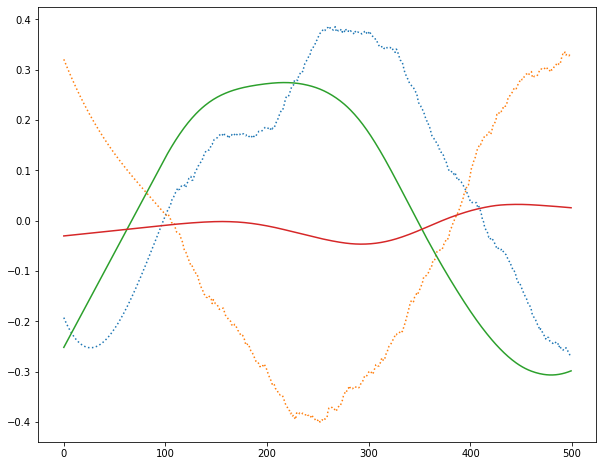

  0%|          | 0/1120 [00:00<?, ?it/s]

Epoch 1


100%|██████████| 1120/1120 [00:06<00:00, 180.74it/s]


Epoch 1 , mean error: 0.0016323881 params: [DeviceArray([[  573.9467,  3652.3582],
             [  949.9611, -5180.38  ]], dtype=float32), DeviceArray([[ 16.146313 , -18.219196 ],
             [ -4.2802086,  31.069527 ]], dtype=float32)]


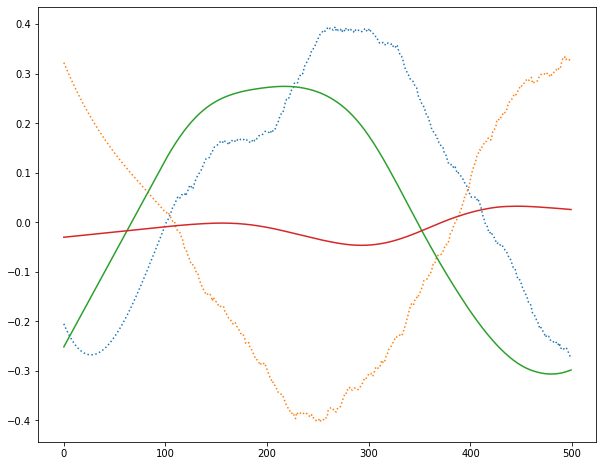

  0%|          | 0/1120 [00:00<?, ?it/s]

Epoch 2


100%|██████████| 1120/1120 [00:06<00:00, 183.42it/s]


Epoch 2 , mean error: 0.0016606606 params: [DeviceArray([[  573.4253,  3652.9702],
             [  943.9141, -5173.0283]], dtype=float32), DeviceArray([[ 16.391293 , -18.942398 ],
             [ -3.6911278,  25.505875 ]], dtype=float32)]


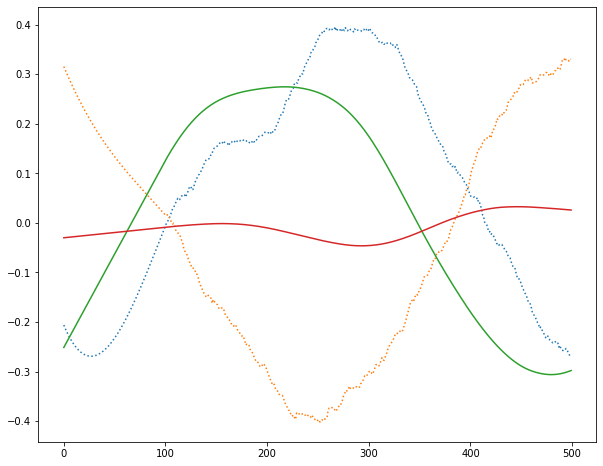

  0%|          | 0/1120 [00:00<?, ?it/s]

Epoch 3


100%|██████████| 1120/1120 [00:06<00:00, 183.32it/s]


Epoch 3 , mean error: 0.0016720612 params: [DeviceArray([[  574.4343,  3649.3577],
             [  940.9512, -5168.013 ]], dtype=float32), DeviceArray([[ 16.740337 , -19.393723 ],
             [ -3.7690349,  24.827595 ]], dtype=float32)]


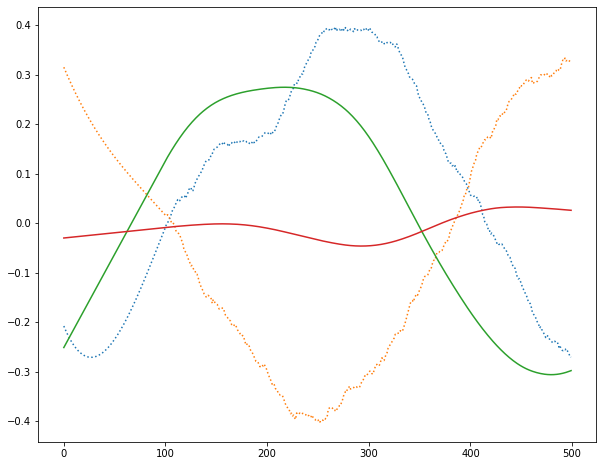

In [278]:


def callback(y_pred, y_true):
    
    plt.figure(figsize=(10, 8))
    plt.plot(shuffler.undo_shuffle(np.squeeze(y_pred))[:500], linestyle="dotted")
    plt.plot(shuffler.undo_shuffle(np.squeeze(y_true))[:500])
    plt.show()


train(params, q_shuffled, q_dot_shuffled, q_dot2_shuffled, f_shuffled, batch_size=128, optimizer=adam, step_size=1e2, epochs=4, callback=callback, batch_forward_pass=batch_forward_pass)